In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [23]:
transform = transforms.ToTensor()

#ransform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.5), (0.5))
#])   -> in this case we well need to use as last activation function the tanh

mnist_data = datasets.MNIST(root=".data", train= True, download = True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size = 64,
                                          shuffle=True)

In [24]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [25]:
class Autoencoder_Linear(nn.Module):

  def __init__(self):
    super().__init__()
    #N, 784 -> 28 x 28 -> number of pixels in the image
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28,128), #this reduce the size of the image from N,28*28 to a representation of N,128
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3), #Final Size -> N, 3
    )

    self.decoder = nn.Sequential(
        nn.Linear(3,12), #N, 3 to N, 784
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28), #Final Size -> N,28*28
        nn.Sigmoid()  # in case [-1, 1] we will need to use nn.tanh
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  

In [30]:
class Autoencoder(nn.Module):

  def __init__(self):
    super().__init__()        
    # N, 1, 28, 28
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
      nn.ReLU(),
      nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
      nn.ReLU(),
      nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
    )
      
    # N , 64, 1, 1
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
      nn.Sigmoid()
    )

  def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  ##nn.MaxPool2D - > nn.MaxUnpool2d

In [31]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [33]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
  for (img, _) in data_loader:
    #img = img.reshape(-1, 28*28)  #use this in linear autoencoder
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch+1}, loss: {loss.item():.4f}")
  outputs.append((epoch, img, recon))

Epoch: 1, loss: 0.0097
Epoch: 2, loss: 0.0065
Epoch: 3, loss: 0.0041
Epoch: 4, loss: 0.0039
Epoch: 5, loss: 0.0035
Epoch: 6, loss: 0.0032
Epoch: 7, loss: 0.0031
Epoch: 8, loss: 0.0024
Epoch: 9, loss: 0.0026
Epoch: 10, loss: 0.0027


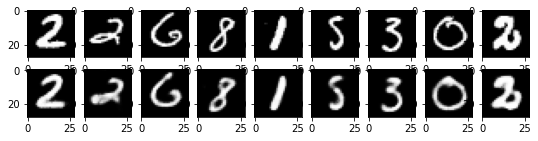

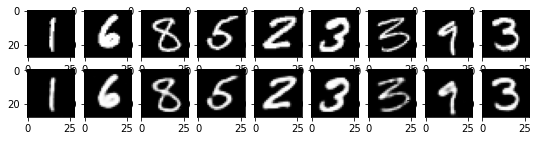

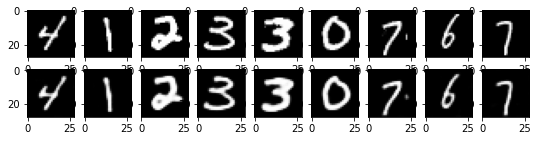

In [34]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])